In [1]:
import arviz as az
import graphviz
import numpy as np
import pandas as pd
import pymc3 as pm
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import scipy.stats as stats
import torch
from pyro.infer import EmpiricalMarginal
from pyro.infer.mcmc import MCMC, NUTS
from torch.autograd import Variable
from torch.nn import functional as F

torch.manual_seed(0)
np.random.seed(0)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


# Introduction to Probabilistic Programming

## Sampling methods

- sampling is difficult even though we know PDF
- but possible
- even though our PDF-like function is not normalized
- algorithms
  - naive sampling
    - only for naive distributions
  - rejection sampling
    - rejects too much candidate samples
    - takes muh time to tune parameter
  - MCMC
    - Metropolis-Hastings
      - accepts all samples after burn-in phase
      - takes too much time to samples from high dimensional distributions
    - Gibbs Sampling
      - good for high dimensional distribution
      - needs to analyze conditional probabilities
    - Hamiltonian Monte Carlo sampling
      - fast
      - needs additional parameters to be tuned
    - NUTS(No U-Turn Sampler)
      - Hamiltonian Monte Carlo Method + auto tuning of step size and number of steps
      - does not use Metropolis acceptance
      - only for continuous parameters which have gradients

## Bayesian network

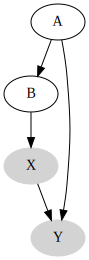

In [2]:
# requirements: install `graphviz` in your system first. e.g. `sudo apt install graphviz`
graphviz.Source("""
digraph {
  
  A -> B;
  A -> Y;
  B -> X;
  X -> Y;
  X,Y [style=filled, color=lightgrey];
}
""")

- We can find simplified joint probability easily

$$
P(A=a,B=b,C=c,X=x,Y=y) \\
= P(a,b,x,y) \\
= P(a)P(b \vert a)P(x \vert b)P(y \vert x,a)
$$

## Posterior probability

$$
P(\theta \vert D) = {{P(D \vert \theta)P(\theta)}\over{P(D)}}
$$

For the bayesian network above,

$$
P(a,b \vert x, y)
= {{P(a, b \vert x, y)P(a, b)}\over{P(x, y)}}
$$
.

- Any probability of continuous random variable equals a point is always `0`.
- Instead, we can consider each of these probabilities as a PDF function of `a`, `b` alternatively.

If `x` and `y` are series of observations, the likelihood part can be decomposed like this.

$$
{{P(a, b \vert x_1, y_1)\cdots P(a, b \vert x_n, y_n)P(a, b)}\over{P(x_1, y_1) \cdots P(x_n, y_n)}}
$$

By the way, to simplify the posterior using information of the bayesian network above.

$$
P(a,b \vert x, y) \\
= {{P(a, b, x,y)}\over{P(x,y)}} \\
= {{P(a)P(b \vert a)P(x \vert b)P(y \vert x,a)}\over{P(x,y)}}
$$
.

- This can be useful for a analytic solution but we don't need to do this manually.
- I guess a probabilistic programming framework will do something similar like this internally to sample from the posterior distribution.

## MAP with sampling methods

1. build a hypothesis model as a Bayesian network
2. sample and find posterior distribution from PDFs
3. pick the modes of parameters from the posterior distribution

## Frameworks - github stars

- `PyMC3`
- `Pyro`
- `TensorFlow probability`
- `Stan`
- `Edward`

![github star history of libraries](./github_star_history.png)

## Titanic example

### Model

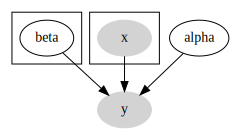

In [3]:
# requirements: install `graphviz` in your system first. e.g. `sudo apt install graphviz`
graphviz.Source("""
digraph {
  subgraph cluster_beta {
    beta;
  }
  
  subgraph cluster_x {
    x [style=filled, color=lightgrey];
  }
  
  alpha -> y;
  beta -> y;
  x -> y;
  y [style=filled, color=lightgrey];
}
""")

$$
\beta \sim N(0, 1) \\
\alpha \sim N(0, 1) \\
\text{y} \sim Bern(sigmoid(\text{x} \cdot \beta + \alpha))) \\
$$

### Preprocessing

#### Load titanic_train dataset

In [4]:
df = pd.read_csv('datasets/titanic_train_kaggle.csv')

#### Split

In [5]:
raw_train_data = df.sample(frac=0.7)
raw_test_data = df.drop(raw_train_data.index) # creates new pd.DataFrame object as always

#### Transform

In [6]:
def get_valid_values(series, min_category_counts=30):
        all_val_counts = series.dropna().value_counts()
        all_val_counts = all_val_counts[all_val_counts >= min_category_counts]
        return all_val_counts.index

class BinaryEncoding():
    """binary-string to one-hot"""
    
    min_category_counts = 30
    
    def __init__(self):
        self.mapping = {} # {field: {class1: 0.0, class2: 1.0}

    def fit(self, df):
        for col_name in df.columns:
            if not pd.api.types.is_string_dtype(df[col_name].dtype):
                continue
            unique_values = get_valid_values(df[col_name], min_category_counts=self.min_category_counts)

            if len(unique_values) != 2:
                continue
            for val in unique_values:
                self.mapping[col_name] = {unique_values[i]: float(i) for i in range(len(unique_values))}

    def transform(self, df):
        for col_name in self.mapping:
            df[col_name] = df[col_name].map(self.mapping[col_name])

class OneHotEncoding():
    """multi-class-string to one-hot"""
    prefix_sep = '!'
    min_category_counts = 30

    def __init__(self):
        self.column_mapping = {} # {field: {class1, class2, class3, ...}}

    def fit(self, df):
        for col_name in df.columns:
            if not pd.api.types.is_string_dtype(df[col_name].dtype):
                continue
            unique_values = get_valid_values(df[col_name], min_category_counts=self.min_category_counts)

            if len(unique_values) <= 2:
                continue
            self.column_mapping[col_name] = set(unique_values)

    def transform(self, df):
        column_names = set(self.column_mapping)
        for col_name in column_names:
            values = self.column_mapping[col_name]
            for val in values:
                new_col_name = "{}{}{}".format(col_name, self.prefix_sep, val)
                df[new_col_name] = (df[col_name] == val).astype('float64')
        df.drop(columns=list(column_names), inplace=True)
    
class Standardization():
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, df):
        self.mean = df.mean()
        self.std = df.std()

    def transform(self, df):
        transform_columns = self.mean.index
        input_columns = set(df.columns)
        for col_name in transform_columns:
            if col_name in input_columns:
                df[col_name] = (df[col_name] - self.mean[col_name])/self.std[col_name] 

class Imputation():
    def __init__(self):
        self.mean = None

    def fit(self, df):
        self.mean = df.mean()

    def transform(self, df):
        for col_name in df.columns:
            if pd.api.types.is_numeric_dtype(df[col_name].dtype):
                df[col_name].fillna(self.mean[col_name], inplace=True)

class ColumnRemover():
    def __init__(self):
        self.column_names = set()

    def fit(self, df):
        for col_name in df.columns:
            if pd.api.types.is_numeric_dtype(df[col_name].dtype):
                self.column_names.add(col_name)
    def transform(self, df):
        for col_name in df.columns:
            if col_name not in self.column_names:
                df.drop(columns=col_name, inplace=True)
                
class FloatConverter():
    def __init__(self):
        self.column_names = set()

    def fit(self, df):
        for col_name in df.columns:
            if pd.api.types.is_numeric_dtype(df[col_name].dtype):
                self.column_names.add(col_name)
    def transform(self, df):
        for col_name in df.columns:
            if col_name in self.column_names:
                df[col_name] = df[col_name].astype('float64')

class Chain():
    def __init__(self, transforms):
        self.transforms = transforms

    def fit_transform(self, df):
        for tr in self.transforms:
            tr.fit(df)
            tr.transform(df)
    
    def transform(self, df):
        for tr in self.transforms:
            tr.transform(df)

In [7]:
target_column_name = 'Survived'
fields_to_ignore = ["Name", "PassengerId", "Ticket"] + [target_column_name]
input_transform_chain = Chain([BinaryEncoding(), OneHotEncoding(), Imputation(), Standardization(), ColumnRemover(), FloatConverter()])
train_data_x = raw_train_data.copy().drop(columns=fields_to_ignore)
input_transform_chain.fit_transform(train_data_x)

label_transform = FloatConverter()
train_data_y = raw_train_data[[target_column_name]].copy()
label_transform.fit(train_data_y)
label_transform.transform(train_data_y)

test_data_x = raw_test_data.copy().drop(columns=fields_to_ignore)
input_transform_chain.transform(test_data_x)

test_data_y = raw_test_data[[target_column_name]].copy()
label_transform.transform(test_data_y)

In [8]:
train_data_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked!C,Embarked!S,Embarked!Q
495,0.813823,-0.734761,0.000000,-0.498973,-0.445714,-0.338418,2.102140,-1.632883,-0.310654
648,0.813823,-0.734761,0.000000,-0.498973,-0.445714,-0.479860,-0.474943,0.611432,-0.310654
278,0.813823,-0.734761,-1.726776,3.597860,0.866199,-0.038128,-0.474943,-1.632883,3.213857
31,-1.587243,1.358805,0.000000,0.525235,-0.445714,2.365465,2.102140,-1.632883,-0.310654
255,0.813823,1.358805,-0.033185,-0.498973,2.178112,-0.322295,2.102140,-1.632883,-0.310654
...,...,...,...,...,...,...,...,...,...
824,0.813823,-0.734761,-2.111683,3.597860,0.866199,0.178131,-0.474943,0.611432,-0.310654
146,0.813823,-0.734761,-0.187147,-0.498973,-0.445714,-0.474828,-0.474943,0.611432,-0.310654
289,0.813823,1.358805,-0.572054,-0.498973,-0.445714,-0.475766,-0.474943,-1.632883,3.213857
29,0.813823,-0.734761,0.000000,-0.498973,-0.445714,-0.472780,-0.474943,0.611432,-0.310654


In [9]:
train_data_y

,Survived
495,0.0
648,0.0
278,0.0
31,1.0
255,1.0
...,...
824,0.0
146,1.0
289,1.0
29,0.0


### Plain logistic regression with PyTorch

In [10]:
x_train = torch.Tensor(train_data_x.values)
y_train = torch.Tensor(train_data_y.values)
x_test = torch.Tensor(test_data_x.values)
y_test = test_data_y.values

class LogisticRegression(torch.nn.Module):
    def __init__(self, n_input_fields):
        super().__init__()
        n_output_fields = 1
        self.linear = torch.nn.Linear(n_input_fields, n_output_fields)

    def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred

model = LogisticRegression(x_train.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
for epoch in range(400):
    model.train()
    optimizer.zero_grad()    # Forward pass
    y_pred = model(x_train)    # Compute Loss
    loss = criterion(y_pred, y_train)    # Backward pass
    loss.backward()
    optimizer.step()

print("weights:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

y_pred = model(x_test)

print("predicted y values:")
for i in range(10):
    print(i, y_pred.data[i][0])

y_pred = y_pred.detach().numpy()
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

weights:
linear.weight tensor([[-0.2082,  0.4820, -0.2443, -0.1933, -0.0492,  0.2240,  0.1178,  0.1126,
          0.0238]])
linear.bias tensor([-0.1466])
predicted y values:
0 tensor(0.7009)
1 tensor(0.5999)
2 tensor(0.5998)
3 tensor(0.5003)
4 tensor(0.5404)
5 tensor(0.4460)
6 tensor(0.5469)
7 tensor(0.5467)
8 tensor(0.2539)
9 tensor(0.3533)
accuracy: 0.8127340823970037


/home/hotohoto/playground/pp_research/venv/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### MAP with PyMC3

In [11]:
x_train = train_data_x.values
y_train = train_data_y.values
x_test = test_data_x.values
y_test = test_data_y.values

In [12]:
basic_model = pm.Model()

with basic_model:
    n_features = x_train.shape[1]
    
    weight = pm.Normal(
        'weight',
        mu=0,
        sigma=1,
        shape=(n_features, 1)
    )

    bias = pm.Normal(
        'bias',
        mu=0,
        sigma=10
    )

    p = pm.math.sigmoid(pm.math.dot(x_train, weight) + bias)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_train)
    
    map_estimate = pm.find_MAP()
    
    for name, node in map_estimate.items():
        print('{:<20} {}'.format(name, node))
        

print("weights:")
weight = map_estimate['weight']
bias = map_estimate['bias']
def sigmoid(x):
    return 1.0 / (1.0 + np.e**(-x))

y_pred = sigmoid(x_test@weight + bias)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)
        

/home/hotohoto/playground/pp_research/venv/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -293.01, ||grad|| = 0.02753: 100%|██████████| 14/14 [00:00<00:00, 1361.41it/s]  


weight               [[-0.86874993]
 [ 1.21562935]
 [-0.4959191 ]
 [-0.24932219]
 [-0.08082288]
 [ 0.10581166]
 [ 0.07507148]
 [-0.07292843]
 [ 0.01185762]]
bias                 -0.7260674390960811
weights:
accuracy: 0.8164794007490637


In [13]:
with basic_model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias, weight]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:12<00:00, 483.35draws/s]


In [14]:
summary = pm.stats.summary(trace)
summary

/home/hotohoto/playground/pp_research/venv/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
weight__0_0,-0.874202,0.140987,0.002530,-1.149609,-0.591656,3357.815470,1.000047
weight__1_0,1.238345,0.113962,0.001870,1.023001,1.462720,3755.856720,1.001076
weight__2_0,-0.508157,0.123820,0.002017,-0.742653,-0.263284,3524.634685,0.999868
weight__3_0,-0.264458,0.130472,0.002358,-0.527581,-0.013832,3249.205990,1.000252
weight__4_0,-0.091028,0.111778,0.001739,-0.303767,0.131808,3646.410448,1.000734
weight__5_0,0.130727,0.148709,0.002541,-0.137114,0.442375,3530.968798,0.999873
weight__6_0,0.078226,0.592370,0.015495,-1.086763,1.231172,1809.936547,0.999801
weight__7_0,-0.071743,0.680773,0.017673,-1.381831,1.282133,1788.057675,0.999791
weight__8_0,0.010993,0.441927,0.011195,-0.831953,0.894059,1805.350119,0.999985
bias,-0.731721,0.111689,0.001934,-0.949454,-0.510943,3198.426304,1.002012


In [15]:
# using posterior mean

def sigmoid(x):
    return 1.0 / (1.0 + np.e**(-x))


weight = np.reshape(summary['mean'][:-1].values, (n_features, 1))
bias = summary['mean'][-1]
print(weight, weight.shape, type(weight))
print(bias, bias.shape, type(bias))

y_pred = sigmoid(x_test@weight + bias)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

[[-0.87420192]
 [ 1.23834521]
 [-0.50815733]
 [-0.26445778]
 [-0.09102787]
 [ 0.13072728]
 [ 0.07822555]
 [-0.07174282]
 [ 0.01099264]] (9, 1) <class 'numpy.ndarray'>
-0.7317210144766704 () <class 'numpy.float64'>
accuracy: 0.8164794007490637


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4437724240>,
      dtype=object)

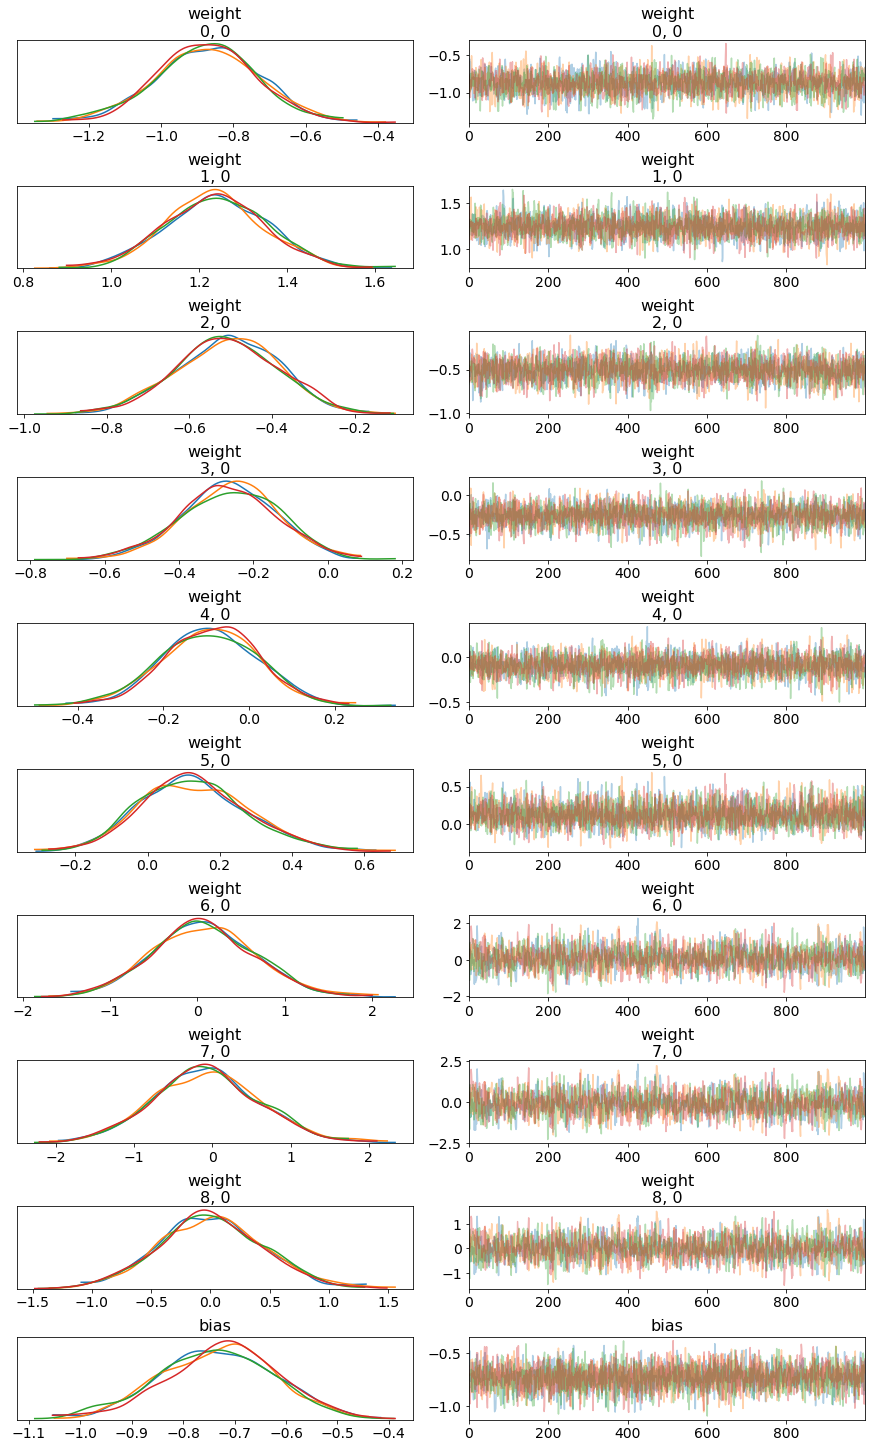

In [16]:
pm.plots.traceplot(trace)

(<Figure size 432x648 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f443e718710>],
       dtype=object))

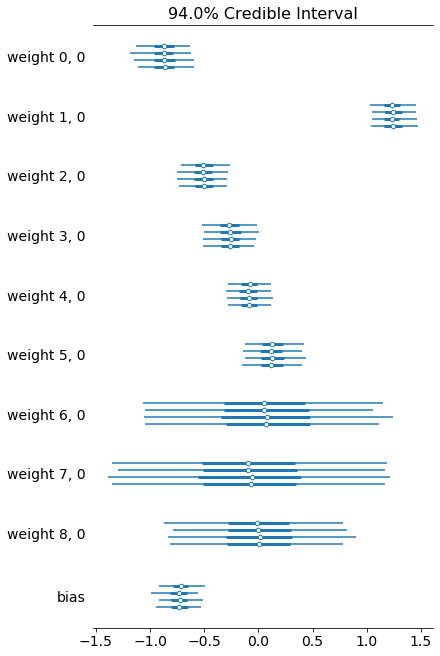

In [17]:
pm.plots.forestplot(trace)

### MAP with Pyro

In [ ]:
x_train = torch.Tensor(train_data_x.values)
y_train = torch.Tensor(train_data_y.values)
x_test = test_data_x.values
y_test = test_data_y.values

n_features = x_train.shape[1]

def model(x_train, y_train):
    weight = pyro.sample('weight', dist.Normal(torch.zeros(n_features, 1), torch.ones(1)))
    bias = pyro.sample('bias', dist.Normal(0, 10))
    return pyro.sample("y_obs", dist.Bernoulli(torch.sigmoid(x_train@weight + bias)), obs=y_train)

nuts_kernel = NUTS(model)
mcmc_sampler = MCMC(nuts_kernel, num_samples=4000, warmup_steps=2000)
posterior = mcmc_sampler.run(x_train, y_train)

Sample:  50%|█████     | 3030/6000 [02:12<02:38, 18.72it/s, step size=1.36e-01, acc. prob=0.905]

In [ ]:
def map_sites(func, posterior, sites):
    marginal = posterior.marginal(sites)
    site_stats = {}
    for site in sites:
        marginal_site = marginal.support(flatten=True)[site]
        site_stats[site] = func(marginal_site.numpy(), site)
    return site_stats

def get_mode(array, name):
    if len(array.shape) == 1:
        names = [name]
    else:
        names = ["{}[{}]".format(name, i) for i in range(array.shape[1])]
    array_ = array.reshape(array.shape[0],-1)
    
    modes = []

    for i in range(array_.shape[1]):
        values =array_[:, i]
        kernel = stats.gaussian_kde(values)
        height = kernel.pdf(values)
        mode_value = values[np.argmax(height)]
        modes.append(mode_value)
    
    return modes


# using estimated mode values

sites = ["weight", "bias"]
modes = map_sites(get_mode, posterior, sites)
print(modes)

weight = np.reshape(np.array(modes['weight']), (n_features, 1))
bias = np.array(modes['bias'])

def sigmoid(x):
    return 1.0 / (1.0 + np.e**(-x))

y_pred = sigmoid(x_test@weight + bias)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

In [ ]:
def get_site_stats(array, name):
    if len(array.shape) == 1:
        names = [name]
    else:
        names = ["{}[{}]".format(name, i) for i in range(array.shape[1])]
    print(names, array.shape)
    array_ = array.reshape(array.shape[0],-1)
    df = pd.DataFrame(array_, columns=names).transpose()
    return df.apply(pd.Series.describe, axis=1)[["mean", "std", "25%", "50%", "75%"]]


sites = ["weight", "bias"]
df_summary = pd.concat([s for s in map_sites(get_site_stats, posterior, sites).values()])
print(df_summary)

In [ ]:
weight = np.reshape(df_summary['mean'][:-1].values, (n_features, 1))
bias = df_summary['mean'][-1]

y_pred = sigmoid(x_test@weight + bias)
y_pred = (y_pred >= 0.5).astype(np.float64)
accuracy_test = np.mean(np.equal(y_pred, y_test))
print("accuracy:", accuracy_test)

In [ ]:
data = az.convert_to_inference_data(posterior)
az.plot_trace(data)

In [ ]:
az.plot_forest(data)

## History of some sampling methods

NUTS(No U-Turn Sampler)

- Hamiltonian Monte Carlo Method + auto tuning of step size and number of steps
- does not use Metropolis acceptance
- only for continuous parameters which have gradients

## References

- [Github star chart](https://star-history.t9t.io/#pymc-devs/pymc3&pyro-ppl/pyro&tensorflow/probability&stan-dev/stan&blei-lab/edward) (use chrome)
- [PyMC3](https://docs.pymc.io/)
- [Pyro](https://pyro.ai/)
- [Faster estimation of Bayesian models in ecology using Hamiltonian Monte Carlo](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12681)
- [MAP lecture note, Standford CS109](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/ppt/22-MAP.pdf)